# Cognitive Model Discovery with SPICE

This tutorial teaches how to use SPICE (SParse and Interpretable Cognitive Equations) to discover reinforcement learning models directly from behavioral data.

First, we will implement a simple model that will recover the famous Rescorla-Wagner equation and train it on simulated data from a two-armed bandit task. Then, we will extend this model with new mechanisms such as asymmetric learning rates, choice perseveration and participant embeddings.

# Installing SPICE

SPICE can be easily installed via pip with the following command:

`pip install autospice`

Which will download and install the latest version.

Alternatively, you can clone [the repository](https://github.com/whyhardt/SPICE) and install via

`pip install -e .`

For a general overview of SPICE, refer to the documentation: https://whyhardt.github.io/SPICE/

## Using on Google Colab

If you are running this notebook on Google Colab, you first need to uninstall and re-install numpy and pandas due to an inconsistency in dependency management. Please execute the following cells to setup your Colab environment and install SPICE.

When it asks to restart the session, please do so before continuing.

In [1]:
# Execute the cell if you are using Google Colab

# !pip uninstall -y numpy pandas
# !pip install numpy==1.26.4 pandas==2.2.2

In [2]:
# Uncomment the code below and execute the cell if you are using Google Colab

# !pip install autospice

# Recovering the Rescorla-Wagner equation with SPICE

The Rescorla-Wagner equation is the basic, well-known equation for associative learning. In our first example, we will start simple by fitting our SPICE model to discover this equation.

The Rescorla-Wagner equation is as follows:

$V_{t+1} = V_t + \alpha (r_t - V_t)$

where $V_t$ is the value state at timestep $t$, $r_t$ is the reward received at time $t$, and $\alpha$ is the learning rate.

For discovering this equation with SPICE, we will first generate synthetic data from a simple Q-learning agent. Then we will implement a simple SPICE RNN and fit the model to simulated data.

## Simulating data
First, we simulate a synthetic dataset from a Q-learning agent performing the two-armed bandit task.

In such bandit tasks the participant has to choose between several options across many trials and receives a reward $r$ each time after selecting one of them.

This reward is based on a reward probability $p(r)$.

In some experiments the reward probabilities of the different options are fixed and in others they have a more dynamic nature.

In our case, the reward probabilities are going to change trial-by-trial randomly based on a drift rate $\sigma$ according to

$p(r;t+1) \leftarrow p(r;t) + d$ with $d \sim \mathcal{N}(0, \sigma)$,

where $d$ is the current drift.

Let's set up the environment first.

In [1]:
import numpy as np
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
from spice.resources.bandits import BanditsDrift

n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

/home/daniel/miniconda3/envs/spice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's see how the reward probabilities of the arms change across trials

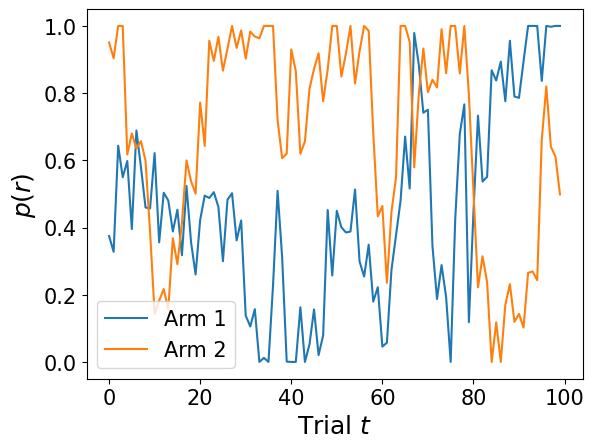

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_trials = 100
reward_probabilities = np.zeros((n_trials, n_actions))

for index_trials in range(n_trials):
    reward_probabilities[index_trials] = environment.reward_probs
    environment.step(choice=0)

for index_action in range(n_actions):
    plt.plot(reward_probabilities[..., index_action], label=f'Arm {index_action+1}')
plt.legend()
plt.xlabel(r'Trial $t$')
plt.ylabel(r'$p(r)$')
plt.show()

Great! After setting up the environment, we can now go on to set up our participant!

The agent's behavior is defined by its parameters. These parameters are set once in the beginning but you can also draw new parameters from a distribution for each new session (i.e. performing $t$ trials).

Let's begin with the simpler case first and keep the parameters fixed for all trials.

We are going to set up a simple Rescorla-Wagner model which has only a learning rate $\alpha$ and an inverse noise temperature $\beta_{reward}$ and generate a dataset with it.

In [4]:
from spice.resources.bandits import AgentQ, create_dataset

agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    beta_reward=3,
)

dataset, _, _ = create_dataset(agent=agent, environment=environment, n_trials=100, n_sessions=100)

# set all participant ids to 0 since this dataset was generated only by one parameterization
dataset.xs[..., -1] = 0

Creating dataset...


100%|██████████| 100/100 [00:01<00:00, 97.87it/s]


Let the agent perform now the task and track how the agent's internal believes change across trials!

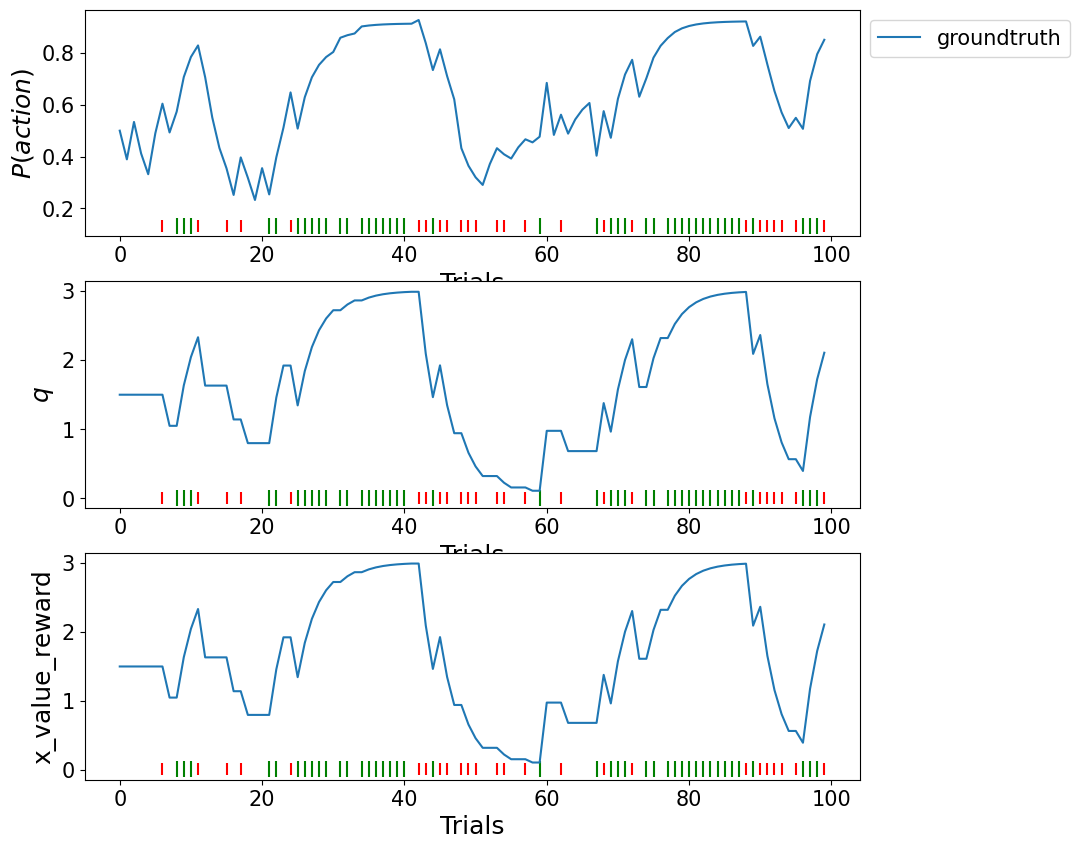

In [5]:
from spice.utils.plotting import plot_session

fig, axs = plot_session(agents = {'groundtruth': agent}, experiment=dataset.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

The green and red ticks at the bottom mark whenever option 1 was chosen and rewarded/not rewarded.

You can take a look at the experiment results either in dataset (which is used for training the RNN) or in the experiments (which is a list of performed sessions; more human-readable)


In [8]:
# print('Inputs (choice item 1 selected; choice item 2 selected; reward 1; reward 2; session id):')
# print(dataset.xs)

# print('Targets (next choice):')
# print(dataset.ys)

Now that we have our data, we can proceed to setup our RNN and train it!

## Implementing the RNN

First, we are going to implement a basic SPICE RNN from scratch and train it on simulated data.

The structure of the RNN is shown in the following figure:

![](https://github.com/whyhardt/SPICE/blob/main/figures/spice_rnn_rescorla_wagner.png?raw=1)

The RNN will inherit from the `BaseRNN`-class in the SPICE library, which itself is a `pytorch.nn.Module`.

We will implement a `forward`-method which is used for prediction. Also, the RNN needs submodules to perform computations. These submodules are stored in the dictionary ` submodules_rnn` with the key `x_ModuleName`. The start of the key `x_` means that we are talking here about a memory state variable of the RNN.

First, we are going to implement the simplest version of the RNN, which will only update the value of the *chosen option* based on the reward and leaves the values of the not chosen options untouched.



In [6]:
from spice.resources.rnn import BaseRNN

class RescorlaWagnerRNN(BaseRNN):

    # set up a dictionary with initial values for each state in memory
    init_values = {
        'x_value_reward': 0.5,
    }

    def __init__(
        self,
        n_actions,
        **kwargs,
    ):
        super(RescorlaWagnerRNN, self).__init__(n_actions=n_actions)

        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)

    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """

        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs

        for timestep, action, reward in zip(timesteps, actions, rewards):

            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('x_value_reward_chosen', self.state['x_value_reward'])

            # Let's perform the belief update for the reward-based value of the chosen option
            # since all values are given to the rnn-module (independent of each other), the chosen value is selected by setting the action to the chosen one
            # if we would like to perform a similar update by calling a rnn-module for the non-chosen action, we would set the parameter to action=1-action.
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=reward,
                )

            # and keep the value of the not-chosen option unchanged
            next_value_reward_not_chosen = self.state['x_value_reward'] * (1-action)

            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen  # memory state = (0.8, 0.3) <- next_value = (0.8, 0) + (0, 0.3)

            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']

        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        # self.state['x_value_reward'] = value_reward
        logits = self.post_forward_pass(logits, batch_first)

        return logits, self.get_state()

After implementing the RNN, we configure it with the sames names that we picked for our modules and signals. We can create a SpiceConfig object to do this.

In [7]:
from spice.estimator import SpiceConfig

rw_config = SpiceConfig(
    # A list of all names of the RNN-modules which are computing the RNN's memory state
    rnn_modules=['x_value_reward_chosen'],

    # A list of all the control signals which are used as inputs to any of the RNN-modules
    control_parameters=['c_action', 'c_reward'],

    # Setup of the SINDy library
    # Determines which terms are allowed as control inputs to each SINDy model in a dictionary.
    # The key is the SINDy-model name (same as RNN-module), value is a list of allowed control inputs from the list of control signals
    library_setup={
        'x_value_reward_chosen': ['c_reward'],
    },

    # Setup of the filtering condition
    # Determines the filtering condition on which samples are selected as training samples for each SINDy-model.
    # Example:
    # Since each RNN-module processes all values at once (but independet from each other), we have to filter for the updates of interest.
    # In the case of the reward-based value of the chosen option this means to use only the chosen items and not the non-chosen ones.
    # Therefore, we can set a filter condition to get rid of all value updates for non-chosen options.
    # The filter dictionary has the following structure:
    # key -> the SINDy model name
    # value -> triplet of values:
    #   1. str: feature name to be used as a filter
    #   2. numeric: the numeric filter condition
    #   3. bool: remove feature from control inputs if not needed as input to the module
    # Multiple conditions can also be given as a list of triplets, e.g. [['c_action', 1, True], ['c_reward', 0, False]]
    filter_setup={
        'x_value_reward_chosen': ['c_action', 1, True],
    },
)

## 3. Fitting SPICE to data

Now that we implemented our RNN, we can train it to see how well it fits the behavior of our synthetic participant.

First, we define a configuration for RNN and SINDy.

You can now use the `SpiceEstimator` to fit the RNN to the data we generated above.

In [8]:
from spice.estimator import SpiceEstimator


spice_estimator = SpiceEstimator(
    rnn_class=RescorlaWagnerRNN,
    spice_config=rw_config,
    learning_rate=1e-2,
    epochs=512,
)

spice_estimator.fit(dataset.xs, dataset.ys)
spice_estimator.print_spice_model()


Training the RNN...
Epoch 512/512 --- L(Train): 0.5427549; Time: 0.07s; Convergence: 1.85e-07
Maximum number of training epochs reached.


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

SPICE modules:
(x_value_reward_chosen)[k+1] = -0.385 1 + 0.684 x_value_reward_chosen[k] + 0.928 c_reward[k]


After training, SPICE displays the discovered equation on the last output line.

It should be similar to `(x_value_reward_chosen)[k+1] = -0.411 1 + 0.682 x_value_reward_chosen[k] + 0.887 c_reward[k]`.

It's maybe not reminding you directly of the classic Rescorla-Wagner model

$V[k+1] = V[k] + \alpha (r[k] - V[k])$

$ ...   = (1 - \alpha) V[k] + \alpha r[k]$,

which is implemented by the synthetic participant, but let's break the identified equation down.

1. The constant `-0.411 1` is applied equally to both arms without considering any reward or the current value. Therefore, it could also be left out (there's actually a way for doing that in the method `create_dataset_sindy` which we could utilize; later more about that).

2. The term `0.682 x_value_reward_chosen[k]` is actually pretty close to the classic model with `alpha_reward = 0.3` when you consider the term $(1 - \alpha)$

3. The term `0.887 c_reward[k]` can be a bit irritating but makes total sense when you consider that the classic model has the scaling factor $\beta$ which is the inverse noise temperature with `beta_reward = 3`. Therefore, considering this scaling factor we get the parameter `0.887 c_reward[k] / beta_reward` $\approx$ `0.3 c_reward[k]`.

By interpreting the identified equation, we can see that the pipeline was able to fit the exact mechanism as implemented in the synthetic participant!

Now, let's see how this model behaves with respect to our synthetic participant.

In the following plot you can compare the action probabilities P(action), the Q-Value, the reward-based as well as the choice-based values.
(You can ignore for now the learning rate $\alpha$)

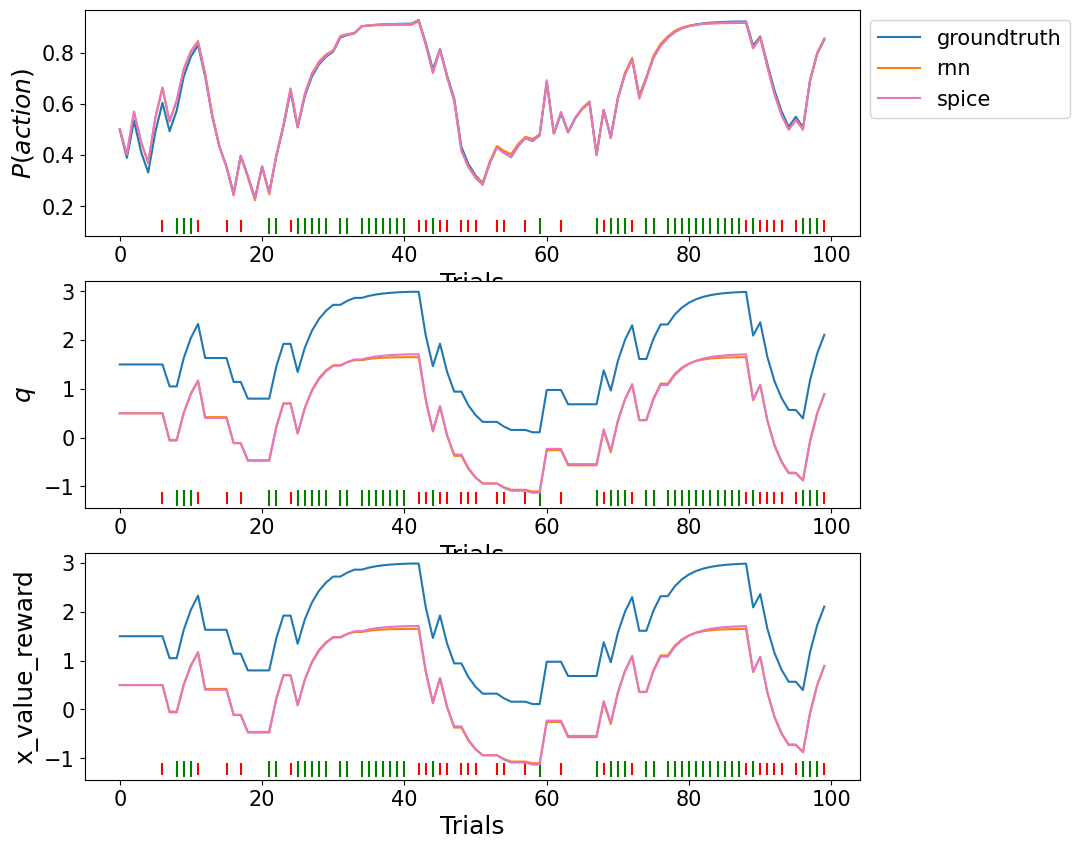

In [9]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

## Saving and loading models

Below is how you can save and load SPICE models. You can specify `path_rnn`, `path_spice` or both to save or load either or both of them.

In [10]:
# Save trained model to file
spice_estimator.save_spice(path_rnn='rnn_model.pkl', path_spice='spice_model.pkl')

# Load saved model
loaded_spice = SpiceEstimator(
    rnn_class=RescorlaWagnerRNN,
    spice_config=rw_config,
)

loaded_spice.load_spice(path_rnn='rnn_model.pkl', path_spice='spice_model.pkl')

# Adding a Forgetting Mechanism



In real-world learning scenarios, humans tend to forget information about options they haven't chosen recently. The forgetting mechanism models this by:
- Gradually decreasing the value of non-chosen actions, or
- Maintaining separate learning rates for chosen and non-chosen actions

In this section we will incorporate an additional RNN submodule to the previous model, which will dynamically handle the reward-based values for the not-chosen action.

First, we simulate data from another agent that has the forgetting mechanism.

In [11]:
# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.2,  # Here we set the forgetting rate to 0.2
)

# Create the dataset
n_trials = 100
n_sessions = 100

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# set all participant ids to 0 since this dataset was generated only by one parameterization
dataset.xs[..., -1] = 0

Creating dataset...


100%|██████████| 100/100 [00:00<00:00, 179.03it/s]


Let's implement the RNN

In [12]:
class ForgettingRNN(BaseRNN):
    
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):
        super(ForgettingRNN, self).__init__(n_actions=n_actions)
        
        self.betas['x_value_reward'] = self.setup_constant()

        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
                
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('x_value_reward_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            # Let's perform the belief update for the reward-based value of the chosen option
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=reward,
                activation_rnn=torch.nn.functional.sigmoid,
                )

            # Now a RNN-module updates the not-chosen reward-based value instead of keeping it the same
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # keep track of the updated value in the memory state
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward']()
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()


FORGETTING_RNN_CONFIG = SpiceConfig(
    # Add already here the new module and update the library and filter setup.
    rnn_modules=['x_value_reward_chosen', 'x_value_reward_not_chosen'],
    
    control_parameters=['c_action', 'c_reward'],

    # The new module which handles the not-chosen value, does not need any additional inputs except for the value
    library_setup={
        'x_value_reward_chosen': ['c_reward'],
        'x_value_reward_not_chosen': [],
    },

    # Further, the new module should be applied only to the not-chosen values
    filter_setup={
        'x_value_reward_chosen': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
    },
)        

In [15]:
spice_estimator = SpiceEstimator(
    rnn_class=ForgettingRNN,
    spice_config=FORGETTING_RNN_CONFIG,
    learning_rate=1e-2,
    epochs=1024,
)

spice_estimator.fit(dataset.xs, dataset.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.6042212; Time: 0.15s; Convergence: 1.04e-04
Maximum number of training epochs reached.


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

SPICE modules:
(x_value_reward_chosen)[k+1] = 0.736 x_value_reward_chosen[k] + 0.249 c_reward[k]
(x_value_reward_not_chosen)[k+1] = 0.116 1 + 0.769 x_value_reward_not_chosen[k]
beta(x_value_reward) = 3.7698


Let's inspect the discovered cognitive features. As you can see, there is a value update for the chosen action, based on the current value (`x_value_reward_chosen`) and the current reward (`c_reward`), same as the previous simple Rescorla-Wagner model.

Additionally, there is now a second mechanism, `x_value_reward_not_chosen` which gets updated based on the value of the non-chosen action, with a weight of 0.8. This is very close to the original data, considering we set a forgetting rate of 0.2, which means the values will be retained with a weight of 0.8.

Now let's see how our model behaves with respect to our synthetic participant.

In the following plot you can compare the action probabilities P(action), the Q-Value, the reward-based as well as the choice-based values.
(You can ignore for now the learning rate $\alpha$)

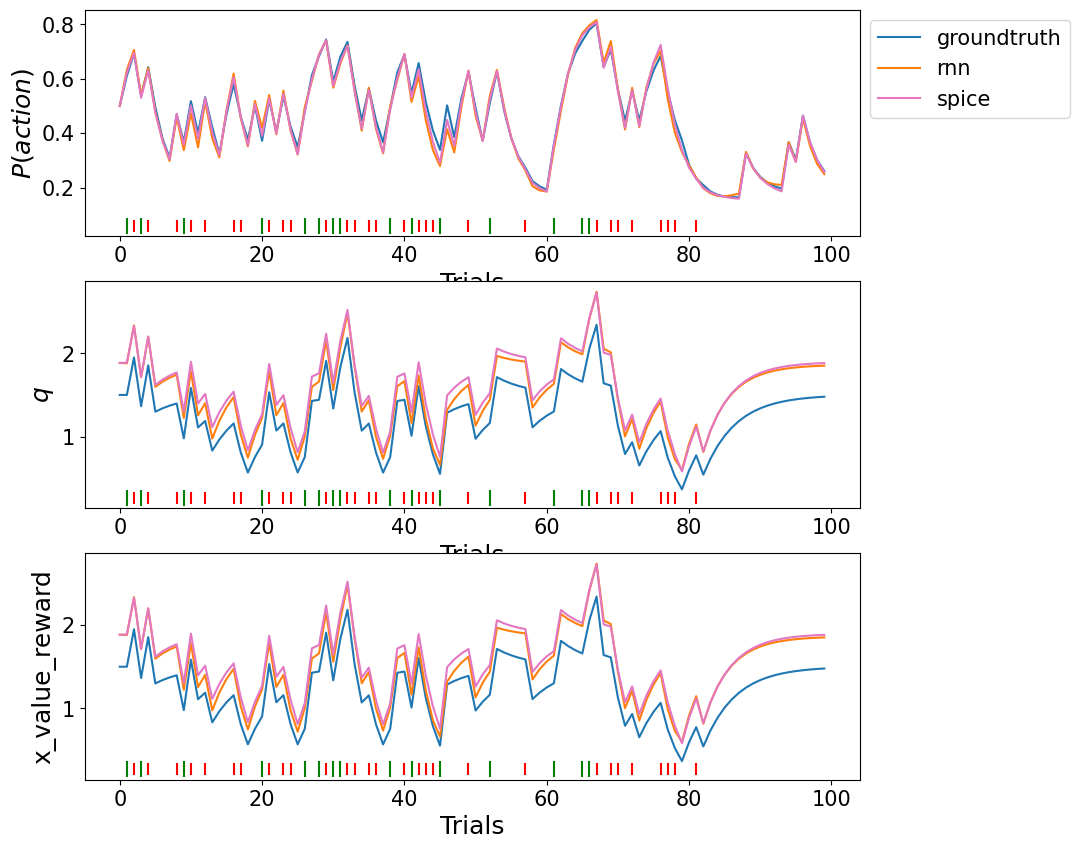

In [16]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward'])
plt.show()

# Modeling Choice Perseveration

Now we will extend the model by adding a choice perseverance mechanism that captures non-goal-directed behavior.
In real-world decision-making, humans don't always choose based purely on expected rewards. Sometimes we tend to repeat previous choices simply because we made them before, independent of their actual value. The choice perseverance mechanism models this by:

Tracking which actions were chosen previously
Gradually increasing the preference for recently chosen actions
Gradually decreasing the preference for non-chosen actions
Allowing for dynamic adjustment of perseverance strength

This module incorporates an additional RNN module which dynamically handles choice-based preferences separately from reward-based learning.

As usual, let us first simulate the data that we will use to train SPICE. This time, the agent will have a choise perseverance mechanism.

In [18]:
# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.2,
    beta_choice=1.,
    alpha_choice=1.,
)

# Create the dataset
n_trials = 100
n_sessions = 100

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# set all participant ids to 0 since this dataset was generated only by one parameterization
dataset.xs[..., -1] = 0

Creating dataset...


100%|██████████| 100/100 [00:00<00:00, 178.56it/s]


And let's implement the RNN with the additional choice mechanism.

In [ ]:
class ChoiceRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_value_choice': 0.,
        }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):
        
        super().__init__(n_actions=n_actions)
        
        # scaling factor (inverse noise temperature) for each participant for the values which are handled by an hard-coded equation
        self.betas['x_value_reward'] = self.setup_constant()
        self.betas['x_value_choice'] = self.setup_constant()
        
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        self.submodules_rnn['x_value_choice_chosen'] = self.setup_module(input_size=0)
        self.submodules_rnn['x_value_choice_not_chosen'] = self.setup_module(input_size=0)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN
        
        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, _, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
        
        # Here we compute now the participant embeddings for each entry in the batch
        beta_reward = self.betas['x_value_reward']()
        beta_choice = self.betas['x_value_choice']()
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('x_value_reward_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_choice_chosen', self.state['x_value_choice'])
            self.record_signal('x_value_choice_not_chosen', self.state['x_value_choice'])
            
            # updates for x_value_reward
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward),
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # updates for x_value_choice
            next_value_choice_chosen = self.call_module(
                key_module='x_value_choice_chosen',
                key_state='x_value_choice',
                action=action,
                inputs=None,
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            next_value_choice_not_chosen = self.call_module(
                key_module='x_value_choice_not_chosen',
                key_state='x_value_choice',
                action=1-action,
                inputs=None,
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            # updating the memory state
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            self.state['x_value_choice'] = next_value_choice_chosen + next_value_choice_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * beta_reward + self.state['x_value_choice'] * beta_choice
            
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

choice_config = SpiceConfig(
    rnn_modules=['x_value_reward_chosen', 'x_value_reward_not_chosen', 'x_value_choice_chosen', 'x_value_choice_not_chosen'],
    control_parameters=['c_action', 'c_reward'],
    # The new module which handles the not-chosen value, does not need any additional inputs except for the value
    library_setup = {
        'x_value_reward_chosen': ['c_reward'],
        'x_value_reward_not_chosen': [],
        'x_value_choice_chosen': [],
        'x_value_choice_not_chosen': [],
    },

    # Further, the new module should be applied only to the not-chosen values
    filter_setup = {
        'x_value_reward_chosen': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
        'x_value_choice_chosen': ['c_action', 1, True],
        'x_value_choice_not_chosen': ['c_action', 0, True],
    }    
)
    

Let's fit our SPICE model to the simulated data and see what happens!

In [23]:
spice_estimator = SpiceEstimator(
    rnn_class=ChoiceRNN,
    spice_config=choice_config,
    learning_rate=1e-2,
    epochs=4096,
)

spice_estimator.fit(dataset.xs, dataset.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 4096/4096 --- L(Train): 0.4836028; Time: 0.22s; Convergence: 3.77e-07
Maximum number of training epochs reached.


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

SPICE modules:
(x_value_reward_chosen)[k+1] = 0.746 x_value_reward_chosen[k] + 0.294 c_reward[k]
(x_value_reward_not_chosen)[k+1] = 0.112 1 + 0.774 x_value_reward_not_chosen[k]
(x_value_choice_chosen)[k+1] = 0.927 1
(x_value_choice_not_chosen)[k+1] = 0.469 1
beta(x_value_reward) = 3.1830
beta(x_value_choice) = 2.2113


Let's see the plot

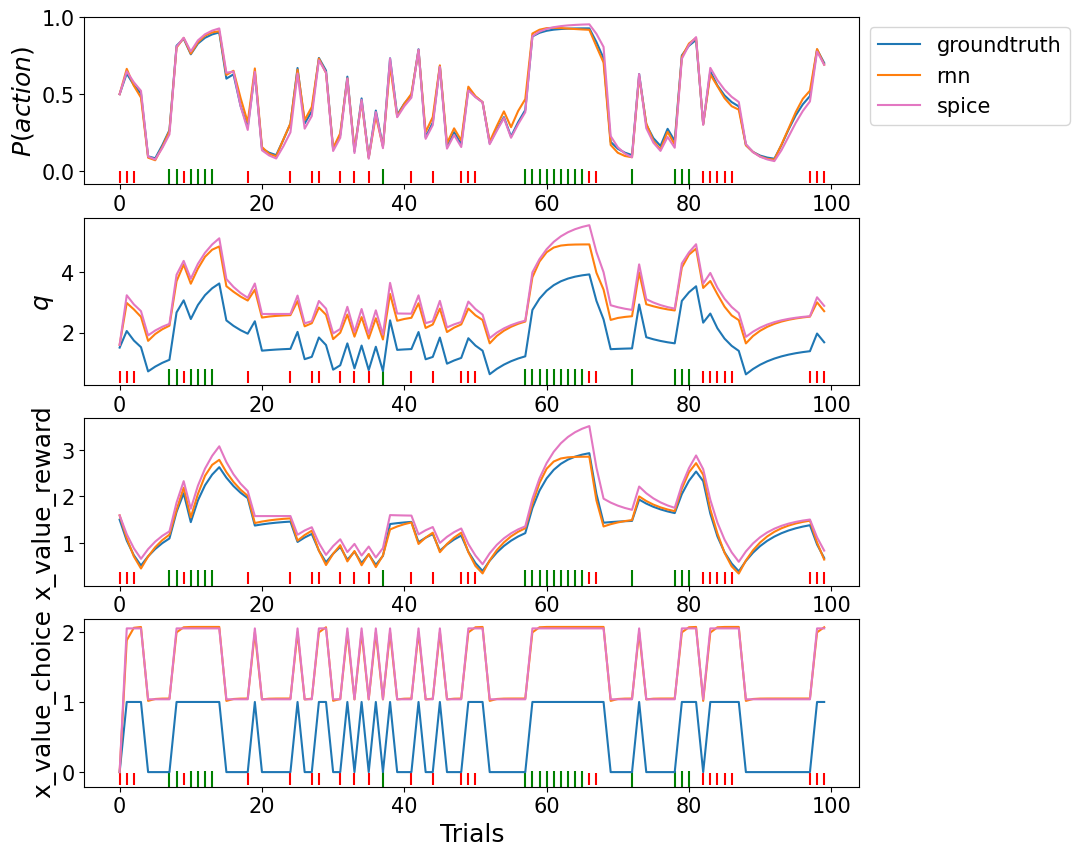

In [24]:
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0], signals_to_plot=['x_value_reward', 'x_value_choice'])
plt.show()